## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

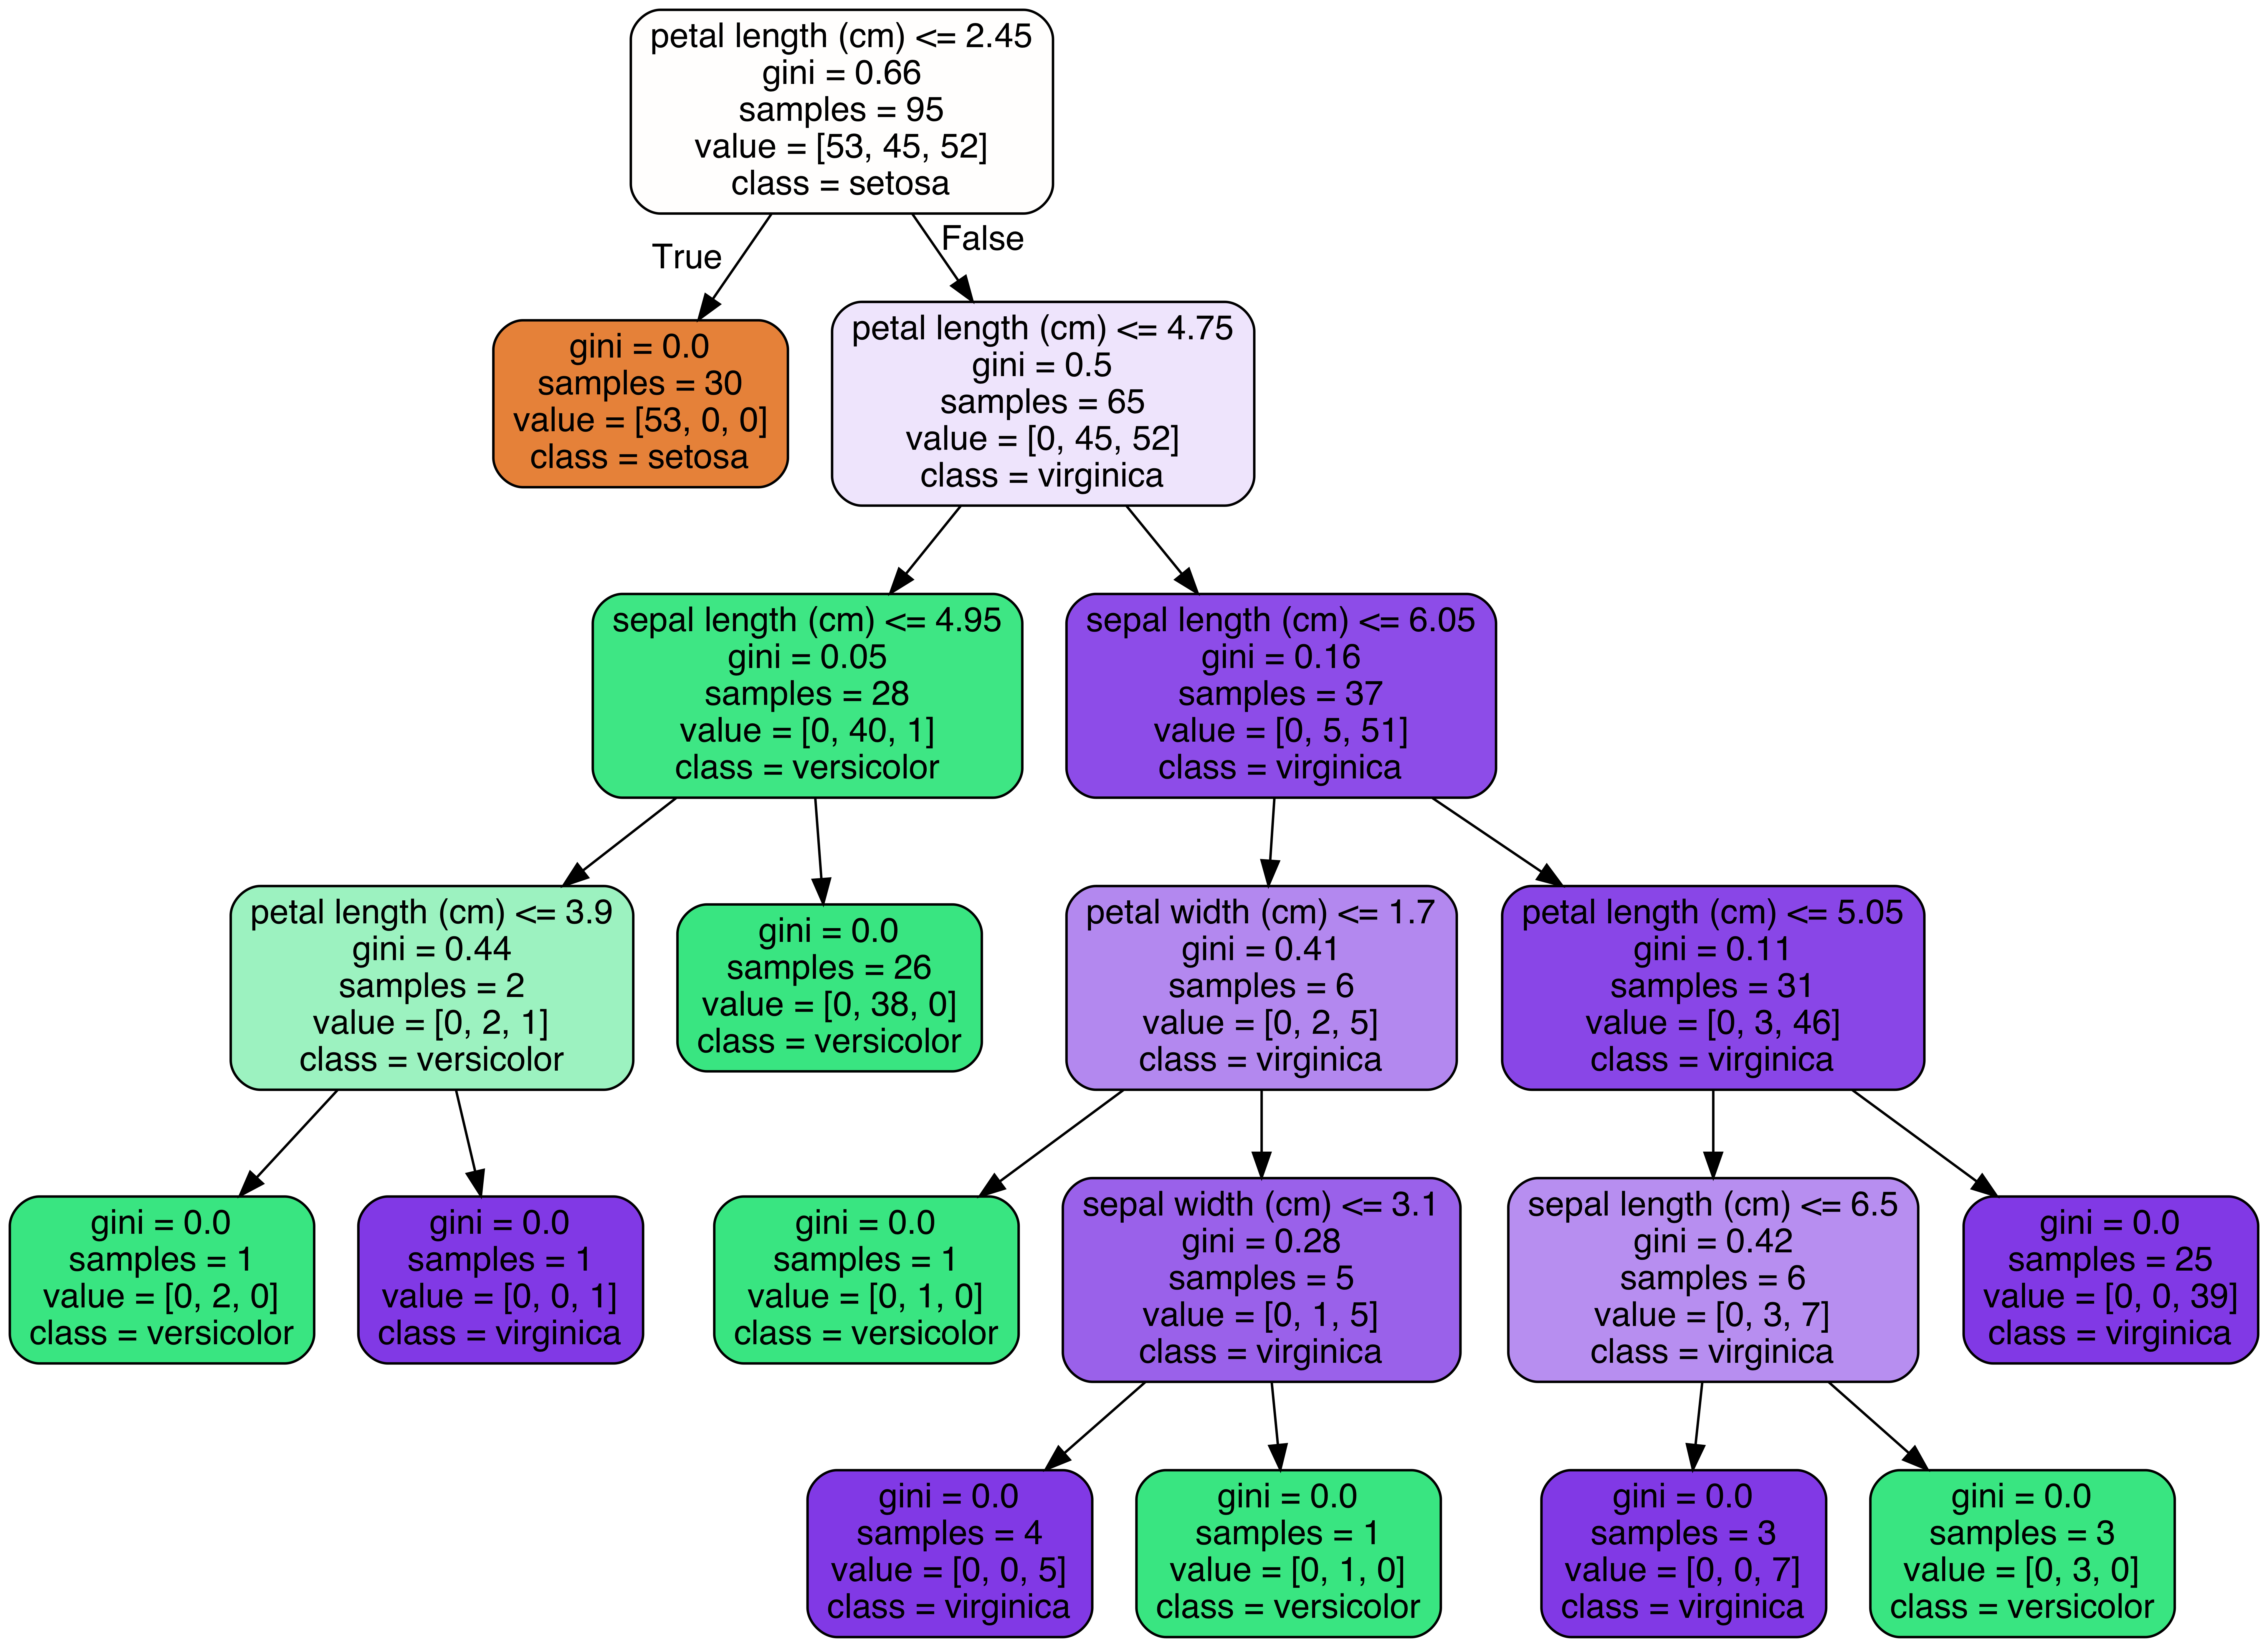

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
# load the dataset 
url='/Users/kouamengoran/Desktop/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,1/22/20,1/23/20,2/5/20,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,1/30/20,3/2/20,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,1/30/20,2/19/20,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,1/26/20,1/30/20,2/15/20,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,1/31/20,2/24/20,NaN,released


In [4]:
# Check the shape of the data set 
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=True)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
3,city,65
4,state,88
5,confirmed_date,141
6,sex,145
7,age,261
8,birth_year,454
9,global_num,904
10,infection_case,1055
11,infected_by,1749
12,contact_number,1807


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
# create a new column n_age which is calculate age base on the birth column    
df['n_age']  = pd.datetime.now().year- df['birth_year']

In [8]:
# check the five first columns of the data set 
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,1/22/20,1/23/20,2/5/20,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,1/30/20,3/2/20,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,1/30/20,2/19/20,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,1/26/20,1/30/20,2/15/20,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,1/31/20,2/24/20,NaN,released,28.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'n_age'],
      dtype='object')

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
#Check first the values  in the column disease
df.disease.unique()

array([nan, True], dtype=object)

In [11]:
 df['disease'].replace({np.nan: 0, True:1}, inplace= True  )

In [12]:
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

In [13]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,NaN,75.0,1/22/20,1/23/20,2/5/20,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,NaN,31.0,NaN,1/30/20,3/2/20,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,1/30/20,2/19/20,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,NaN,9.0,1/26/20,1/30/20,2/15/20,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,1/31/20,2/24/20,NaN,released,28.0


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [14]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
df[['global_num','birth_year','infection_order',
                        'infected_by','contact_number']]=imputer.fit_transform(df[['global_num','birth_year','infection_order',
                        'infected_by','contact_number']])


In [15]:
df.isnull().sum().sort_values(ascending=True)

patient_id               0
global_num               0
birth_year               0
country                  0
province                 0
disease                  0
infection_order          0
infected_by              0
contact_number           0
city                    65
state                   88
confirmed_date         141
sex                    145
age                    261
n_age                  454
infection_case        1055
released_date         1995
symptom_onset_date    2025
deceased_date         2186
dtype: int64

In [16]:
counts= df.city.value_counts()
print(counts)

Gyeongsan-si       535
Cheonan-si          98
Seongnam-si         89
Bonghwa-gun         60
Gumi-si             59
                  ... 
Taebaek-si           1
Yeongyang-gun        1
Wuhan                1
Anseong-si           1
Jeungpyeong-gun      1
Name: city, Length: 134, dtype: int64


In [17]:
mask = df["city"].isin(counts[counts<15].index)
df['city'][mask]= "Others"

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df['city'].value_counts()

Gyeongsan-si     535
Others           477
Cheonan-si        98
Seongnam-si       89
Bonghwa-gun       60
Gumi-si           59
Chilgok-gun       49
Pohang-si         47
Andong-si         47
Cheongdo-gun      43
Bucheon-si        41
Sejong            41
Uiseong-gun       40
Yecheon-gun       36
Yeongcheon-si     36
Dongnae-gu        29
etc               26
Nam-gu            25
Dongdaemun-gu     25
Yongin-si         24
Guro-gu           22
Gimcheon-si       21
Changwon-si       21
Seongju-gun       20
Suwon-si          20
Seo-gu            19
Gyeongju-si       19
Geochang-gun      19
Gangseo-gu        18
Eunpyeong-gu      18
Haeundae-gu       17
Wonju-si          17
Gwanak-gu         17
Nowon-gu          16
Songpa-gu         16
Gangnam-gu        16
Yangcheon-gu      15
Sangju-si         15
Name: city, dtype: int64

<p> The most frequent state is Gyeongsan-si, So we will try fill out the missing value in the state  by  Gyeongsan-si</p> 

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [19]:
# fill the nan values in the city  column with the most frequent category
df['city'].fillna(df['city'].mode()[0], inplace = True)

In [20]:
#df.city.isnull().sum()

In [21]:
# fill the na values in the state column with the most frequent category 
df['state'].fillna (df['state'].mode()[0], inplace =True)

In [22]:
#df['state'].isnull().sum()

In [23]:
# fill the NaN value  in the sex column with the mos frequent category
df['sex'].fillna (df['sex'].mode()[0], inplace =True)

In [24]:
#df['sex'].isnull().sum()

In [25]:
df['infection_case'].fillna(df['infection_case'].mode()[0], inplace =True)

In [26]:
#df['infection_case'].isnull().sum()

In [27]:
df['age'].fillna(df['age'].mode()[0], inplace =True)

In [28]:
#df['age'].isnull().sum()

In [29]:
# fill the NaN value in the n_age column with the mean
df['n_age'].fillna(df['n_age'].mean(), inplace=True)

In [30]:
#df['n_age'].isnull().sum()

 **<font color='teal'> Check for any remaining null values.</font>**

In [31]:
df.isnull().sum().sort_values(ascending=True)

patient_id               0
contact_number           0
infected_by              0
infection_order          0
state                    0
disease                  0
city                     0
infection_case           0
country                  0
age                      0
birth_year               0
sex                      0
global_num               0
province                 0
n_age                    0
confirmed_date         141
released_date         1995
symptom_onset_date    2025
deceased_date         2186
dtype: int64

In [32]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,1/22/20,1/23/20,2/5/20,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Others,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,1/30/20,3/2/20,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Others,0,contact with patient,2.0,2.002000e+09,17.0,NaN,1/30/20,2/19/20,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Others,0,overseas inflow,1.0,2.600789e+09,9.0,1/26/20,1/30/20,2/15/20,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Others,0,contact with patient,2.0,1.000000e+09,2.0,NaN,1/31/20,2/24/20,NaN,released,28.0


Remove date columns from the data.


In [33]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [34]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

Review the count of unique values by column.

In [35]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                 38
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [36]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.017133
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
dtype: float64


Review the range of values per column.

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


In [38]:
df.describe(include=["O"]).T

,count,unique,top,freq
sex,2218,2,female,1316
age,2218,11,20s,728
country,2218,4,Korea,2206
province,2218,17,Gyeongsangbuk-do,1054
city,2218,38,Gyeongsan-si,600
infection_case,2218,16,contact with patient,1585
state,2218,3,isolated,1879


### Check for duplicated rows

In [39]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [40]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending = False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,38
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

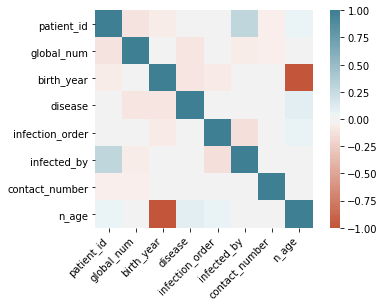

In [41]:
# Correlation heat map for the feature
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

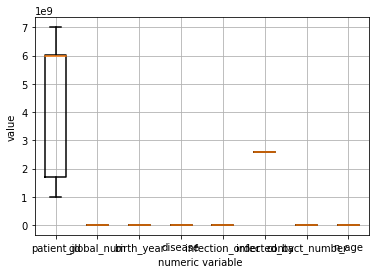

In [42]:
# demonstrate how to customize the display different elements:
ax = df.plot(kind='box',
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0)
ax.set_xlabel('numeric variable ')
ax.set_ylabel('value')
plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

In [43]:
# create a  todummy_list of the categorical variables 
todummy_list= ['sex','age','country','province','city', 'infection_case']

In [44]:
# A dummy function 
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df= df.drop(x, 1)
        df= pd.concat([df, dummies], axis=1)
    return df

In [45]:
# create a dataFrame with dummies called DFWD 
DFWD= dummy_df(df, todummy_list)

In [46]:
DFWD.head()

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,state,n_age,sex_female,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,1964.0,0,1.0,2.600789e+09,75.0,released,56.0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,1987.0,0,1.0,2.600789e+09,31.0,released,33.0,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,1964.0,0,2.0,2.002000e+09,17.0,released,56.0,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,1991.0,0,1.0,2.600789e+09,9.0,released,29.0,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,1992.0,0,2.0,1.000000e+09,2.0,released,28.0,1,...,0,0,0,0,0,1,0,0,0,0


In [47]:
DFWD.columns

Index(['patient_id', 'global_num', 'birth_year', 'disease', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age', 'sex_female',
       'sex_male', 'age_0s', 'age_100s', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'country_China', 'country_Korea', 'country_Mongolia',
       'country_Thailand', 'province_Busan', 'province_Chungcheongbuk-do',
       'province_Chungcheongnam-do', 'province_Daegu', 'province_Daejeon',
       'province_Gangwon-do', 'province_Gwangju', 'province_Gyeonggi-do',
       'province_Gyeongsangbuk-do', 'province_Gyeongsangnam-do',
       'province_Incheon', 'province_Jeju-do', 'province_Jeollabuk-do',
       'province_Jeollanam-do', 'province_Sejong', 'province_Seoul',
       'province_Ulsan', 'city_Andong-si', 'city_Bonghwa-gun',
       'city_Bucheon-si', 'city_Changwon-si', 'city_Cheonan-si',
       'city_Cheongdo-gun', 'city_Chilgok-gun', 'city_Dongdaemun-gu',
       'city_

In [48]:
DFWD.shape

(2218, 97)

In [49]:
X= DFWD.drop(['state','patient_id'], axis = 1)
y =DFWD.state

In [50]:
X.head()

,global_num,birth_year,disease,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,age_0s,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,2.0,1964.0,0,1.0,2.600789e+09,75.0,56.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,5.0,1987.0,0,1.0,2.600789e+09,31.0,33.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,6.0,1964.0,0,2.0,2.002000e+09,17.0,56.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,7.0,1991.0,0,1.0,2.600789e+09,9.0,29.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,9.0,1992.0,0,2.0,1.000000e+09,2.0,28.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split the data into test and train subsamples

In [51]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [52]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [53]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.858
Random Forest: f1-score=0.831


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [55]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0]
 [  0 358  10]
 [  0  52  17]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.97 0.03]
 [0.   0.75 0.25]]


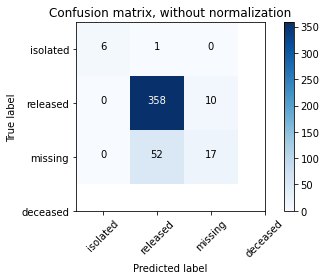

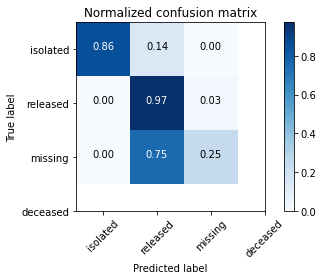

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


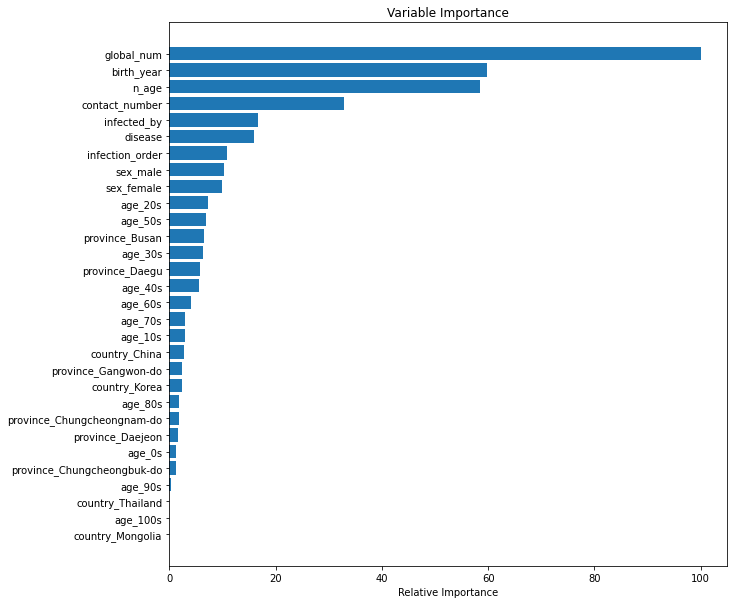

In [57]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.